In [0]:
dbfs:/FileStore/shared_uploads/podurikarthikeya69@gmail.com/cf_lgbm.csv

In [0]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("Cost Forecasting with LGBM") \
    .getOrCreate()

In [0]:
file_path = "dbfs:/FileStore/shared_uploads/podurikarthikeya69@gmail.com/cf_lgbm.csv"  # Adjust this path
data_df = spark.read.csv(file_path, header=True, inferSchema=True)
data_df.show()


+--------------+------+------+------+------------+------------+--------------+----------+----------------+----------------+------------------------+----+---------+-----+-----+-----------+---------------------+-------------------------+
|    HostItemID|  Cost|  List|OnHand|MonthsNoSale|LastSaleDate|PriorYearSales|OnOrderQty|BestReorderPoint|SafetyStockLevel|MonthsWithAtLeastOneSale|Year|    Month|Sales|Lag_1|HolidayFlag|InventoryDiff_Reorder|InventoryDiff_SafetyStock|
+--------------+------+------+------+------------+------------+--------------+----------+----------------+----------------+------------------------+----+---------+-----+-----+-----------+---------------------+-------------------------+
|PMP*14680*2541|381.96|873.72|   184|          17|  2021-04-17|           217|        62|              74|              39|                       8|2021|  January|   39|  NaN|          0|                  110|                       70|
|PMP*14680*2541| 385.0|873.72|   184|          17|  2021

In [0]:
import pandas as pd
pandas_df = data_df.toPandas()

pandas_df['LastSaleDate'] = pd.to_datetime(pandas_df['LastSaleDate'])

pandas_df['Year'] = pandas_df['LastSaleDate'].dt.year
pandas_df['Month'] = pandas_df['LastSaleDate'].dt.month

lgbm_df = pandas_df[['Year', 'Month', 'Cost']]
print(lgbm_df.head())

   Year  Month    Cost
0  2021      4  381.96
1  2021      4  385.00
2  2021      4  390.50
3  2021      4  395.75
4  2021      4  400.00


In [0]:
from sklearn.model_selection import train_test_split

X = lgbm_df[['Year', 'Month']]
y = lgbm_df['Cost']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

Train size: 22, Test size: 6


In [0]:
!pip install lightgbm

     |████████████████████████████████| 3.6 MB 6.1 MB/s 
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-04e5802a-dd2c-4fd0-94de-d50edd5cc97e/bin/python -m pip install --upgrade pip' command.


In [0]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
    'num_leaves': 31,
    'verbose': -1
}

num_boost_round = 1000
best_rmse = float('inf')
best_model = None

for i in range(num_boost_round):
    model = lgb.train(params, train_data, num_boost_round=i + 1, valid_sets=[test_data])
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    print(f"Iteration {i + 1}, RMSE: {rmse:.2f}")

    if rmse < best_rmse:
        best_rmse = rmse
        best_model = model
    else:
        print(f"Early stopping at iteration {i + 1} with best RMSE: {best_rmse:.2f}")
        break

y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


Iteration 1, RMSE: 60.88
Iteration 2, RMSE: 60.88
Early stopping at iteration 2 with best RMSE: 60.88
Mean Absolute Error (MAE): 60.87
Mean Squared Error (MSE): 3706.49
Root Mean Squared Error (RMSE): 60.88


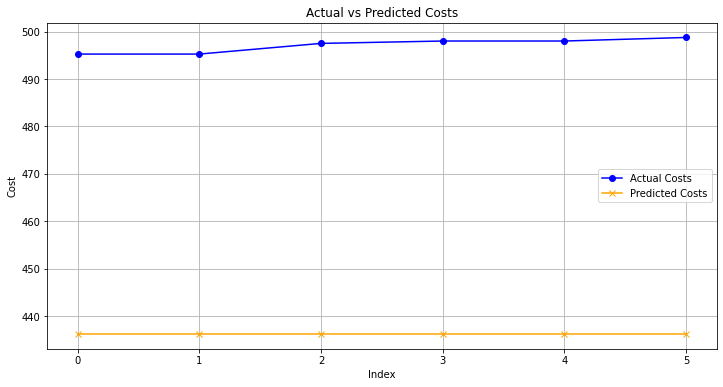

In [0]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual Costs', color='blue', marker='o')
plt.plot(y_pred, label='Predicted Costs', color='orange', marker='x')
plt.title('Actual vs Predicted Costs')
plt.xlabel('Index')
plt.ylabel('Cost')
plt.legend()
plt.grid()
plt.show()

In [0]:
!pip install mlflow

  Using cached mlflow-2.16.2-py3-none-any.whl (26.7 MB)
  Using cached SQLAlchemy-2.0.35-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.1 MB)
  Using cached graphene-3.3-py2.py3-none-any.whl (128 kB)
  Using cached docker-7.1.0-py3-none-any.whl (147 kB)
  Using cached flask-3.0.3-py3-none-any.whl (101 kB)
  Using cached gunicorn-23.0.0-py3-none-any.whl (85 kB)
  Using cached Markdown-3.7-py3-none-any.whl (106 kB)
  Using cached alembic-1.13.3-py3-none-any.whl (233 kB)
  Using cached mlflow_skinny-2.16.2-py3-none-any.whl (5.6 MB)
  Using cached sqlparse-0.5.1-py3-none-any.whl (44 kB)
  Using cached opentelemetry_api-1.27.0-py3-none-any.whl (63 kB)
  Using cached opentelemetry_sdk-1.27.0-py3-none-any.whl (110 kB)
  Using cached cloudpickle-3.0.0-py3-none-any.whl (20 kB)
  Using cached importlib_metadata-8.5.0-py3-none-any.whl (26 kB)
  Using cached PyYAML-6.0.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (737 kB)
  Using cached GitPython-3.1.43-py3-none-any.whl 

In [0]:
with mlflow.start_run():
    mlflow.lightgbm.log_model(best_model, "LGBM_Cost_Model")  # Updated the model log name
    mlflow.log_param("learning_rate", params['learning_rate'])
    mlflow.log_param("num_leaves", params['num_leaves'])
    mlflow.log_param("train_size", len(X_train))
    mlflow.log_param("test_size", len(X_test))

mlflow.end_run()

2024/10/07 18:32:34 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /local_disk0/repl_tmp_data/ReplId-7a445-efcb2-7ea1d-b/tmp0awww0yz/model, flavor: lightgbm). Fall back to return ['lightgbm==4.5.0']. Set logging level to DEBUG to see the full traceback. 
2024/10/07 18:32:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/07 18:32:36 INFO mlflow.tracking._tracking_service.client: 🏃 View run colorful-rook-120 at: https://community.cloud.databricks.com/ml/experiments/4498943658610049/runs/0f4f3e3b1e7a4ad3a3bd2685eec41552.
2024/10/07 18:32:36 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/4498943658610049.
